In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

## Utils

In [3]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [4]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print('\n')
#     pprint(pruned_trained_tree)

In [5]:
default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
                      dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
                      dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Car dataset

## Dataset preparation

In [6]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
car_dataset.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,vhigh,med,4,2,med,low,unacc
1,high,high,3,4,small,med,unacc
2,low,med,5more,2,med,low,unacc
3,med,med,2,more,med,low,unacc
4,med,med,5more,4,big,low,unacc


unacc    573
acc      166
good      34
vgood     32
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

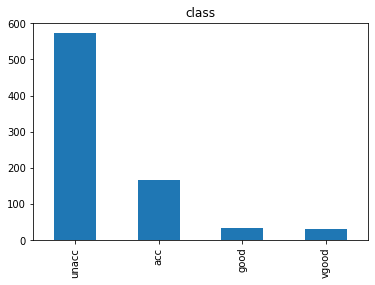

In [7]:
car_set_for_training, car_testing = data_utils.data_split(car_dataset, 70)
car_training, car_validation = data_utils.split_training_data_for_pruning(car_set_for_training)
print(car_training['CLASS'].value_counts())
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [8]:
car_training

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,vhigh,med,4,2,med,low,unacc
1,high,high,3,4,small,med,unacc
2,low,med,5more,2,med,low,unacc
3,med,med,2,more,med,low,unacc
4,med,med,5more,4,big,low,unacc
...,...,...,...,...,...,...,...
800,med,med,3,more,med,high,vgood
801,med,low,5more,more,med,high,vgood
802,low,med,5more,2,small,low,unacc
803,med,med,4,2,big,high,unacc


<AxesSubplot:title={'center':'class'}>

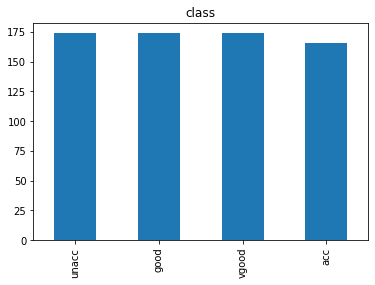

In [9]:
#Target for all 174
resampling_car = car_training.copy()
unacc_part = resampling_car[resampling_car['CLASS'] == 'unacc']
acc_part = resampling_car[resampling_car['CLASS'] == 'acc'] 
vgood_part = resampling_car[resampling_car['CLASS'] == 'vgood'] 
good_part = resampling_car[resampling_car['CLASS'] == 'good'] 


unacc_downsample = resample(unacc_part, 
                                 replace=False,     
                                 n_samples=174)

vgood_part_upsampled = resample(vgood_part, 
                                 replace=True,     
                                 n_samples=174)
good_part_upsampled = resample(good_part, 
                                 replace=True,     
                                 n_samples=174)

# Combine majority class with upsamplet minority class
balanced_car_training= pd.concat([unacc_downsample, acc_part, vgood_part_upsampled, good_part_upsampled])
balanced_car_training = balanced_car_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training = balanced_car_training.sample(frac=1).reset_index(drop=True)

car_training = balanced_car_training.copy()
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [10]:
car_training.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,med,low,5more,more,small,low,unacc
1,low,high,3,4,big,high,vgood
2,vhigh,low,4,2,big,med,unacc
3,low,low,5more,more,big,med,good
4,high,low,3,more,med,med,acc


## Model Training

In [11]:
train_tree_for_different_heuristics(car_training, car_testing, car_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 82.08% | training 97.09% | levels 10 | leafs 96
After Pruning:
Accuracy for: testing 82.47% | training 96.22% | levels 10 | leafs 88


Before Pruning - heuristic = info_gain
Accuracy for: testing 82.08% | training 97.09% | levels 10 | leafs 96
After Pruning:
Accuracy for: testing 82.47% | training 96.22% | levels 10 | leafs 88


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 82.66% | training 95.35% | levels 10 | leafs 106
After Pruning:
Accuracy for: testing 83.43% | training 94.48% | levels 10 | leafs 102


Before Pruning - heuristic = distance_measure
Accuracy for: testing 52.22% | training 77.47% | levels 10 | leafs 173
After Pruning:
Accuracy for: testing 58.77% | training 63.08% | levels 10 | leafs 114


Before Pruning - heuristic = j_measure
Accuracy for: testing 82.47% | training 97.09% | levels 10 | leafs 95
After Pruning:
Accuracy for: testing 82.85% | training 96.51% | levels

# CMC Dataset

## Dataset preparation

In [12]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,30,4,4,1,1,1,1,4,0,3
1,43,3,3,6,1,0,3,2,0,2
2,36,2,1,6,1,1,2,1,0,2
3,41,2,4,1,1,1,2,3,0,1
4,39,3,4,3,1,1,1,4,0,1


1    287
3    228
2    172
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

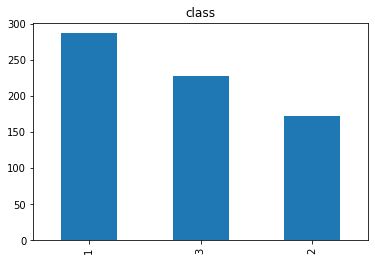

In [13]:
cmc_set_for_training, cmc_testing = data_utils.data_split(cmc_dataset, 70)
cmc_training, cmc_validation = data_utils.split_training_data_for_pruning(cmc_set_for_training)
print(cmc_training['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [14]:
train_tree_for_different_heuristics(cmc_training, cmc_testing, cmc_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 47.74% | training 81.08% | levels 30 | leafs 157
After Pruning:
Accuracy for: testing 58.37% | training 64.34% | levels 28 | leafs 49


Before Pruning - heuristic = info_gain
Accuracy for: testing 45.48% | training 55.02% | levels 62 | leafs 194
After Pruning:
Accuracy for: testing 42.53% | training 48.03% | levels 46 | leafs 88


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 43.89% | training 56.77% | levels 62 | leafs 196
After Pruning:
Accuracy for: testing 42.08% | training 48.76% | levels 44 | leafs 88


Before Pruning - heuristic = distance_measure
Accuracy for: testing 42.76% | training 51.82% | levels 38 | leafs 125
After Pruning:
Accuracy for: testing 44.57% | training 43.38% | levels 20 | leafs 21


Before Pruning - heuristic = j_measure
Accuracy for: testing 45.48% | training 55.02% | levels 62 | leafs 194
After Pruning:
Accuracy for: testing 42.53% | training 48.03% | level

# Adult Dataset

## Data preparation

In [15]:
"""
TODO:
Drop rows with invalid values like '?'
"""
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,34,State-gov,252529,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,48,United-States,<=50K
1,31,Private,187560,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Private,287927,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,16,United-States,<=50K
3,51,Private,175339,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,47,United-States,>50K
4,24,Private,198148,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,30,United-States,<=50K


In [16]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week','CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,CLASS
0,34,State-gov,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,48,<=50K
1,31,Private,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Male,40,<=50K
2,50,Private,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,16,<=50K
3,51,Private,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,47,>50K
4,24,Private,Some-college,10,Never-married,Other-service,Own-child,White,Male,30,<=50K


<=50K    11550
>50K      3644
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

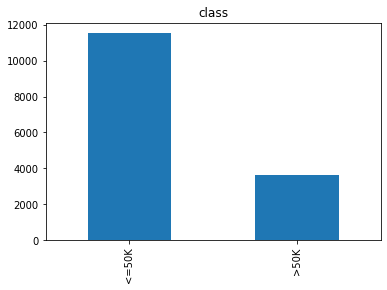

In [17]:
adult_set_for_training, adult_testing = data_utils.data_split(adult_dataset, 70)
adult_training, adult_validation = data_utils.split_training_data_for_pruning(adult_set_for_training)

print(adult_training['CLASS'].value_counts())
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

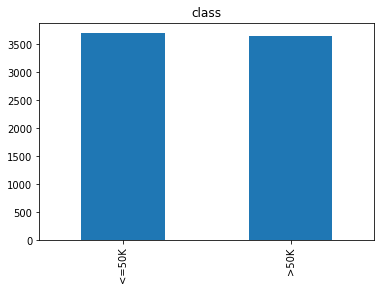

In [18]:
resampling_adult = adult_training.copy()
less_50k_part = resampling_adult[resampling_adult['CLASS'] == '<=50K']
more_50k_part = resampling_adult[resampling_adult['CLASS'] == '>50K'] 

less_50k_part_downsampled = resample(less_50k_part, 
                                 replace=False,    
                                 n_samples=3706)

# Combine minority class with downsampled majority class
balanced_adult_training = pd.concat([less_50k_part_downsampled, more_50k_part])
balanced_adult_training = balanced_adult_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training = balanced_adult_training.sample(frac=1).reset_index(drop=True)

adult_training = balanced_adult_training.copy()
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [19]:
train_tree_for_different_heuristics(adult_training, adult_testing, adult_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 77.33% | training 82.20% | levels 24 | leafs 432
After Pruning:
Accuracy for: testing 79.18% | training 80.16% | levels 24 | leafs 173


Before Pruning - heuristic = info_gain
Accuracy for: testing 66.47% | training 70.18% | levels 212 | leafs 345
After Pruning:
Accuracy for: testing 75.71% | training 50.42% | levels 2 | leafs 2


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 66.23% | training 69.82% | levels 214 | leafs 329
After Pruning:
Accuracy for: testing 75.71% | training 50.42% | levels 2 | leafs 2


Before Pruning - heuristic = distance_measure
Accuracy for: testing 70.43% | training 72.60% | levels 14 | leafs 345
After Pruning:
Accuracy for: testing 74.86% | training 58.90% | levels 14 | leafs 105


Before Pruning - heuristic = j_measure
Accuracy for: testing 66.47% | training 70.18% | levels 212 | leafs 345
After Pruning:
Accuracy for: testing 75.71% | training 50.42% | leve